In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import zipfile

In [ ]:
import tensorflow

from tensorflow.python.keras.models import load_model
from keras.preprocessing.image import img_to_array
tensorflow.__version__

'2.8.0'

In [ ]:
%tensorflow_version 2.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.



#Acessando Arquivos


In [ ]:
'''path = "/content/drive/MyDrive/Reconhecimento_emoções/Material.zip"
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall('./')
zip_object.close'''

'path = "/content/drive/MyDrive/Reconhecimento_emoções/Material.zip"\nzip_object = zipfile.ZipFile(file = path, mode = "r")\nzip_object.extractall(\'./\')\nzip_object.close'

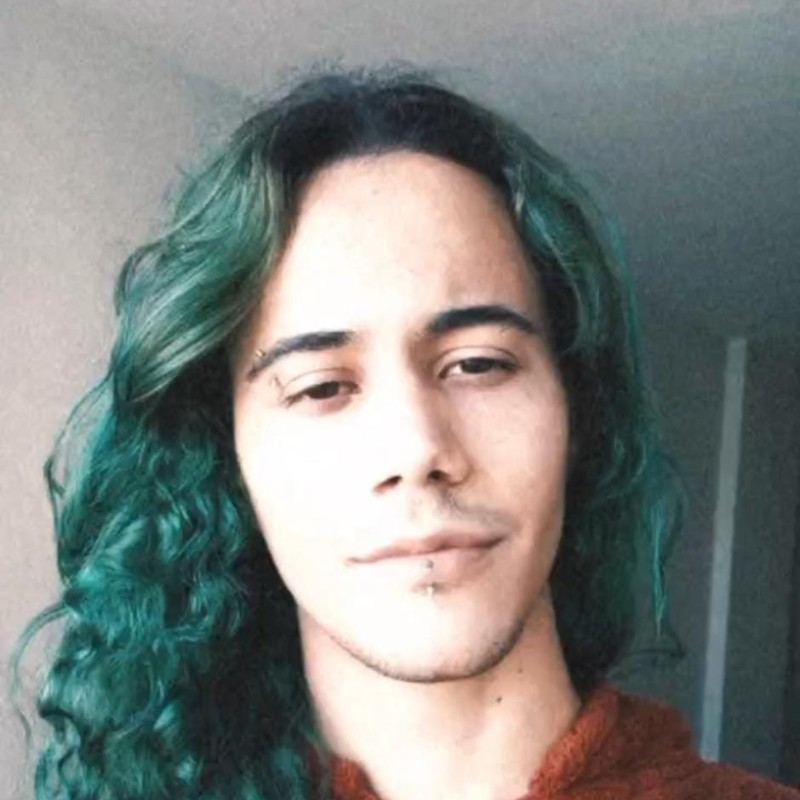

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Reconhecimento_emoções/Material/testes/teste_eu1.jpeg')
cv2_imshow(imagem)

In [ ]:
imagem.shape

(800, 800, 3)

#Carregando os modelos

In [ ]:
# Caminho para o modelo e classificador
cascade_faces = "/content/drive/MyDrive/Reconhecimento_emoções/Material/haarcascade_frontalface_default.xml" # detecção de face
caminho_modelo = "/content/drive/MyDrive/Reconhecimento_emoções/Material/modelo_01_expressoes.h5" # modelo pré treinado

# Carregando modelo e classificador para detecção de faces
face_detection = cv2.CascadeClassifier(cascade_faces)
from keras.layers import BatchNormalization

# Objeto customizado para incluir BatchNormalization, pois o keras não reconhece esta camada do modelo..
custom_objects = {'BatchNormalization': BatchNormalization}

classificador_emocoes = load_model(caminho_modelo, compile = False, custom_objects=custom_objects) #modelo
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]

In [ ]:
original = imagem.copy() # cópia da imagem original
faces = face_detection.detectMultiScale(original, scaleFactor = 1.1,minNeighbors = 3, minSize = (20,20))

In [ ]:
faces

array([[191, 199, 422, 422]], dtype=int32)

- array com a posição de onde começa a face e o tamanho da caixa que a contém
- tem formato de matriz pois pode detectar mais de uma face

In [ ]:
len(faces)

1

In [ ]:
faces.shape

(1, 4)

# Extração do ROI

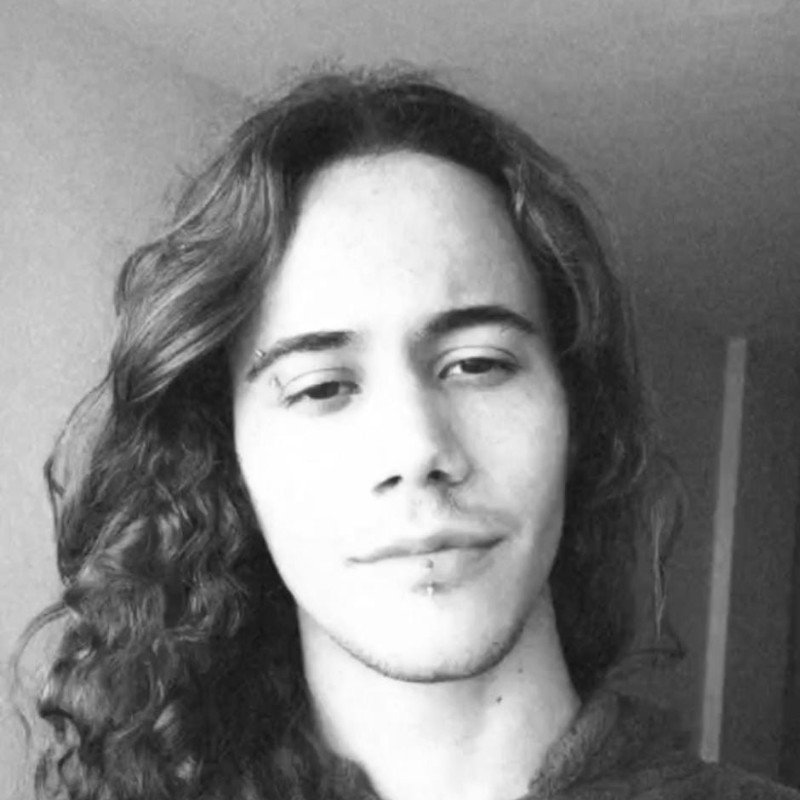

In [ ]:
#Primeiro passo:conversão para escala de cinza
cinza = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(cinza)

In [ ]:
cinza.shape
# agora a imagem tem apenas 1 canal de cor

(800, 800)

In [ ]:
roi = cinza[191:191 + 480, 191:199+422]

coordenadas das arestas do quadrado com offset   definido pelo face_detection.detectMultiScale

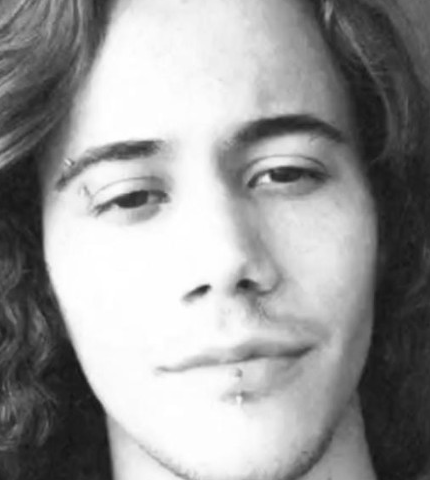

In [ ]:
cv2_imshow(roi)

In [ ]:
roi.shape

(500, 422)

Redução da dimensionalidade para diminuir o tempo de execução das redes neurais:

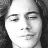

In [ ]:
roi = cv2.resize(roi, (48,48))
cv2_imshow(roi)

In [ ]:
roi.dtype

dtype('uint8')

**Normalização dos dados no intervalo [0,1]para rtabalhar com CNN:**

In [ ]:
#casting dos valores int para float
roi = roi.astype('float')
roi.dtype

dtype('float64')

In [ ]:
roi = roi/255
roi

array([[0.50980392, 0.52941176, 0.51372549, ..., 0.40392157, 0.4       ,
        0.38039216],
       [0.55294118, 0.58039216, 0.50588235, ..., 0.38431373, 0.39215686,
        0.38039216],
       [0.42352941, 0.49019608, 0.5372549 , ..., 0.31764706, 0.35686275,
        0.35294118],
       ...,
       [0.23137255, 0.19607843, 0.14509804, ..., 0.1372549 , 0.12156863,
        0.12941176],
       [0.22352941, 0.19607843, 0.16078431, ..., 0.10588235, 0.11764706,
        0.14901961],
       [0.16862745, 0.2       , 0.14509804, ..., 0.10980392, 0.13333333,
        0.20784314]])

convertendo a imagem para arrays:

In [ ]:
roi = img_to_array(roi)

In [ ]:
roi

array([[[0.50980395],
        [0.5294118 ],
        [0.5137255 ],
        ...,
        [0.40392157],
        [0.4       ],
        [0.38039216]],

       [[0.5529412 ],
        [0.5803922 ],
        [0.5058824 ],
        ...,
        [0.38431373],
        [0.39215687],
        [0.38039216]],

       [[0.42352942],
        [0.49019608],
        [0.5372549 ],
        ...,
        [0.31764707],
        [0.35686275],
        [0.3529412 ]],

       ...,

       [[0.23137255],
        [0.19607843],
        [0.14509805],
        ...,
        [0.13725491],
        [0.12156863],
        [0.12941177]],

       [[0.22352941],
        [0.19607843],
        [0.16078432],
        ...,
        [0.10588235],
        [0.11764706],
        [0.14901961]],

       [[0.16862746],
        [0.2       ],
        [0.14509805],
        ...,
        [0.10980392],
        [0.13333334],
        [0.20784314]]], dtype=float32)

- A imagem tem três dimensões: duas espaciais e uma dimensão para cor

In [ ]:
roi.shape

(48, 48, 1)

- A terceira dimensão é o canal da cor. O tensorflow requer uma dimensão para cor, e o valor 1 indica que há apenas uma: o cinza

In [ ]:
roi = np.expand_dims(roi, axis = 0)

In [ ]:
roi.shape

(1, 48, 48, 1)

- 1 imagem de dimensões 48x48, com 1 canal de cor cinza

# Previsão

preds = variável que vai receber as probabilidades de cada emoção. O modelo carregado na variavel classificador_emocoes é chamado com a função predict, aplicada à imagem **roi** que carrega a imagem do rosto a ser classificado. O valor entre colchetes indica o índice da imagem no roi

In [ ]:
preds = classificador_emocoes.predict(roi)[0]

array de probabilidade para cada uma das classes.

In [ ]:
preds

array([0.03731368, 0.00084858, 0.0239569 , 0.5889694 , 0.04644283,
       0.01001731, 0.29245126], dtype=float32)

In [ ]:
len(preds)

7

Classificação da emoção na imagem:

In [ ]:
emotion_probability = np.max(preds)
emotion_probability

0.5889694

In [ ]:
preds.argmax()

3

In [ ]:
label = expressoes[preds.argmax()]
label

'Feliz'

#Resultados

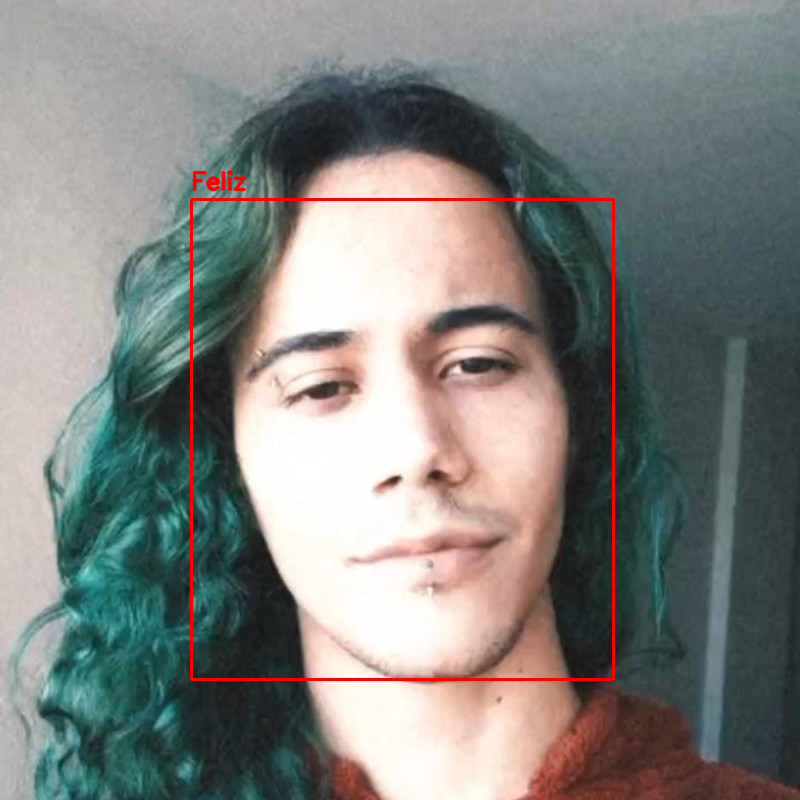

In [ ]:
cv2.putText(original, label, (191, 199 -10), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0,0,255), 2, cv2.LINE_AA)
cv2.rectangle(original, (191,199), (191+422, 199+480), (0,0,255),2)
cv2_imshow(original)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
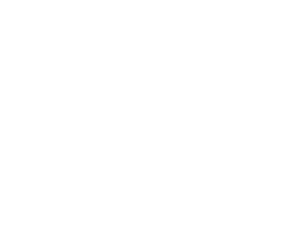

In [ ]:
probabilidades = np.ones((250,300,3),dtype = 'uint8')*255
probabilidades

acabei não usando já que deixei a legenda na foto

In [ ]:
probabilidades.shape

(250, 300, 3)

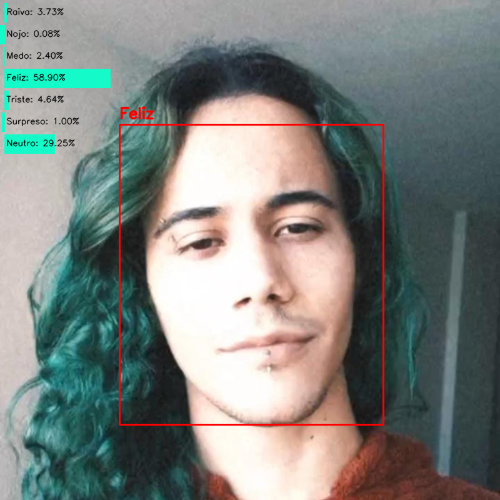

In [ ]:
if len(faces) == 1:
  for (i, (emotion, prob)) in enumerate(zip(expressoes, preds)):
    #print(i, emotion, prob)
    text = "{}: {:.2f}%".format(emotion, prob * 100)
    w = int(prob * 300)
    cv2.rectangle(original, (7, (i * 35) + 5), (w, (i * 35) + 35), (200, 250, 20), -1)
    cv2.putText(original, text, (10, (i * 35) + 23), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 1, cv2.LINE_AA)
original = cv2.resize(original, (500,500))
cv2_imshow(original)

Decidi colocar a legenda das barras na imagem original pra poupar espaço, e redimensionar pois ela é mt grande. Por algum motivo as barras não estão alinhadas à esquerda...